In [4]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20,15)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from math import log, exp
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from scipy.stats import skew


font = {'family':'DejaVu Sans', 'size': 20}
matplotlib.rc('font', **font)


train = pd.read_csv('train.csv', index_col = 0)
print (train.head())

Populating the interactive namespace from numpy and matplotlib
    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
Id                                    ...                             
1          Lvl    AllPub    Inside    ...            0    NaN   NaN   
2          Lvl    AllPub       FR2    ...            0    NaN   NaN   
3          Lvl    AllPub    Inside    ...            0    NaN   NaN   
4          Lvl    AllPub    Corner    ...            0    NaN   NaN   
5          Lv

c:\users\chester\appdata\local\programs\python\python35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log', 'exp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


We will get a hold of the price distribution first, by plotting the price histogram

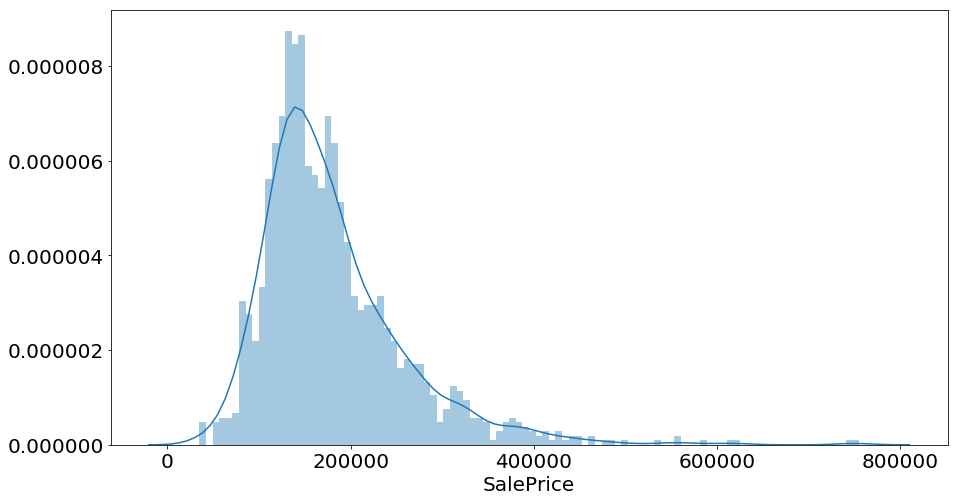

The skewness coefficient is: 1.880940746034036


In [3]:

plt.figure(figsize=(15,8))
sns.distplot(train['SalePrice'], bins=100)
plt.show()

print ('The skewness coefficient is: {}'.format(skew(train['SalePrice'])))

The distribution looks heavily skewed, taking the natural log should help us get back a normal distribution

New skewness is 0.121210


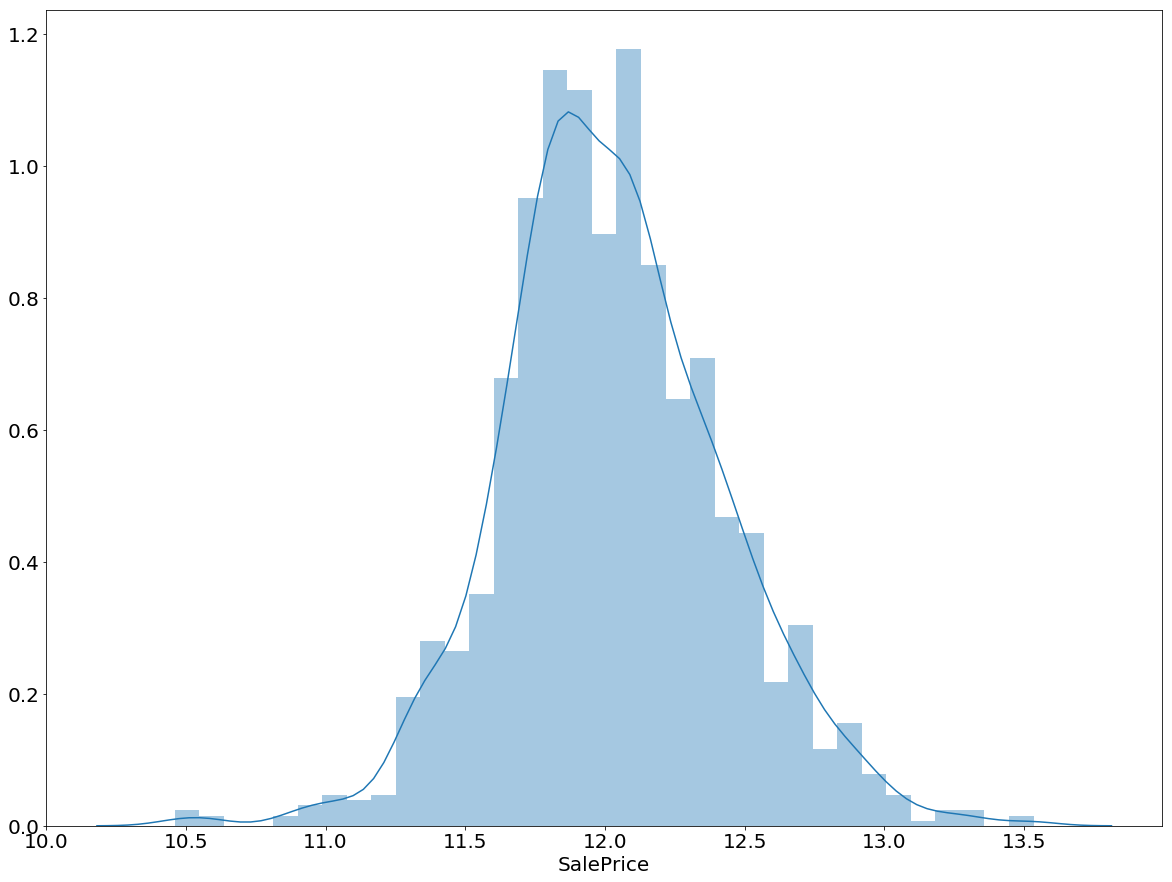

In [19]:
new_price = train['SalePrice'].apply(log)
train['SalePrice'] = new_price
_ = sns.distplot(new_price)

print ('New skewness is %f' % skew(new_price))

According to the attribute description file, the fields explicitly related to location are: MSZoning and Neighborhood. Although non-trivial, let's also take the slope of the property into account as it may give insights of rather the property is on a hill.


In [21]:
print (train[['MSZoning', 'Neighborhood']].head())

   MSZoning Neighborhood
Id                      
1        RL      CollgCr
2        RL      Veenker
3        RL      CollgCr
4        RL      Crawfor
5        RL      NoRidge


Before we even begin, let's take a look at the correlation matrix between each variable.

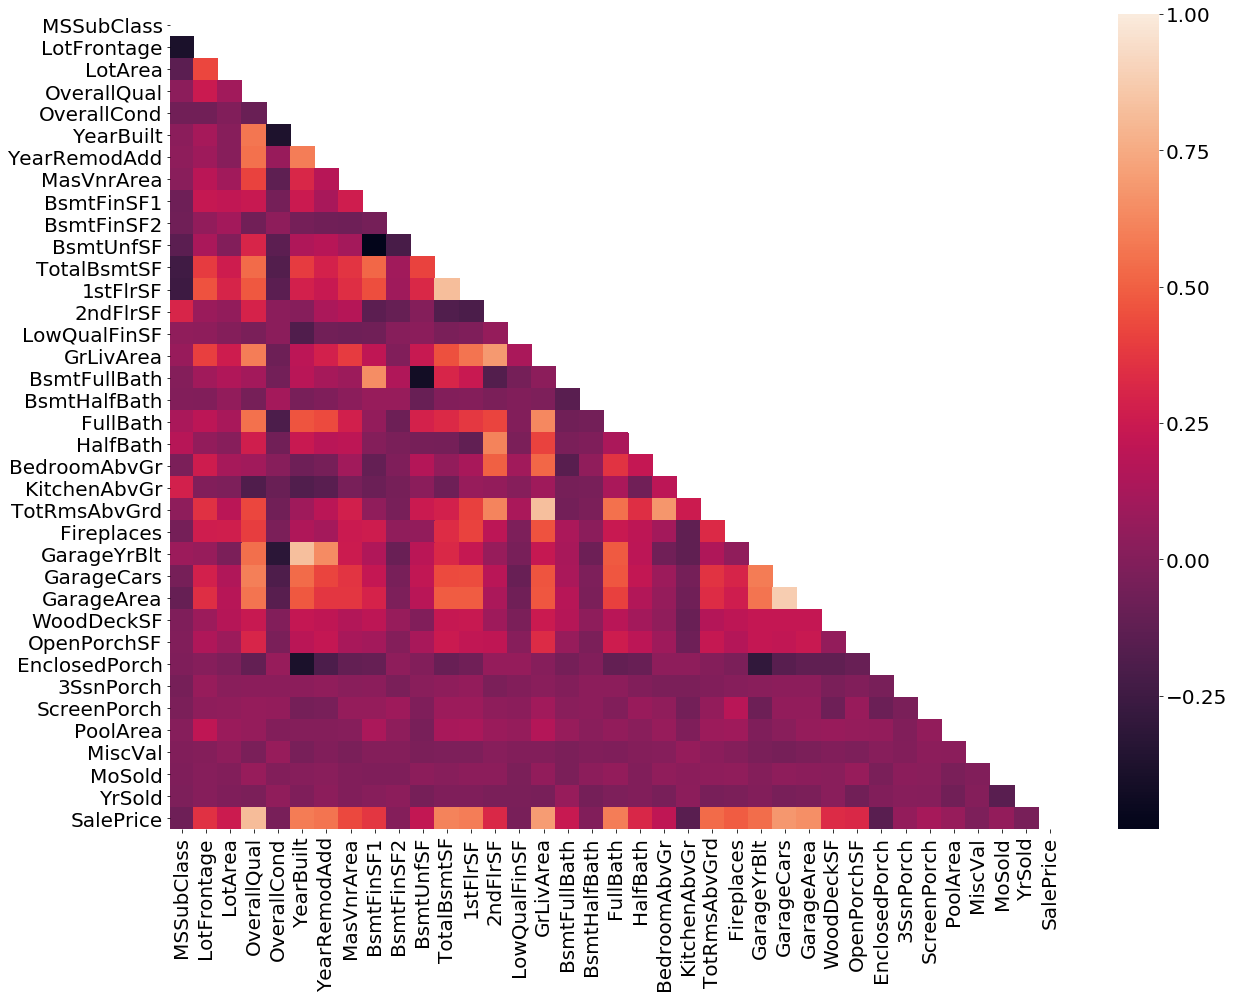

In [20]:
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask)

Looks to me there are only a few variables that have a larger correlation with sale price, they are 
OverallQual, YearBuilt, TotalBsmtSF, TotalRmsAbvGrd, GrLivArea, Fullbath, FirePlaces, GarageCars and GaragArea. 

We should further examine their numerical correlation with the saleprice.

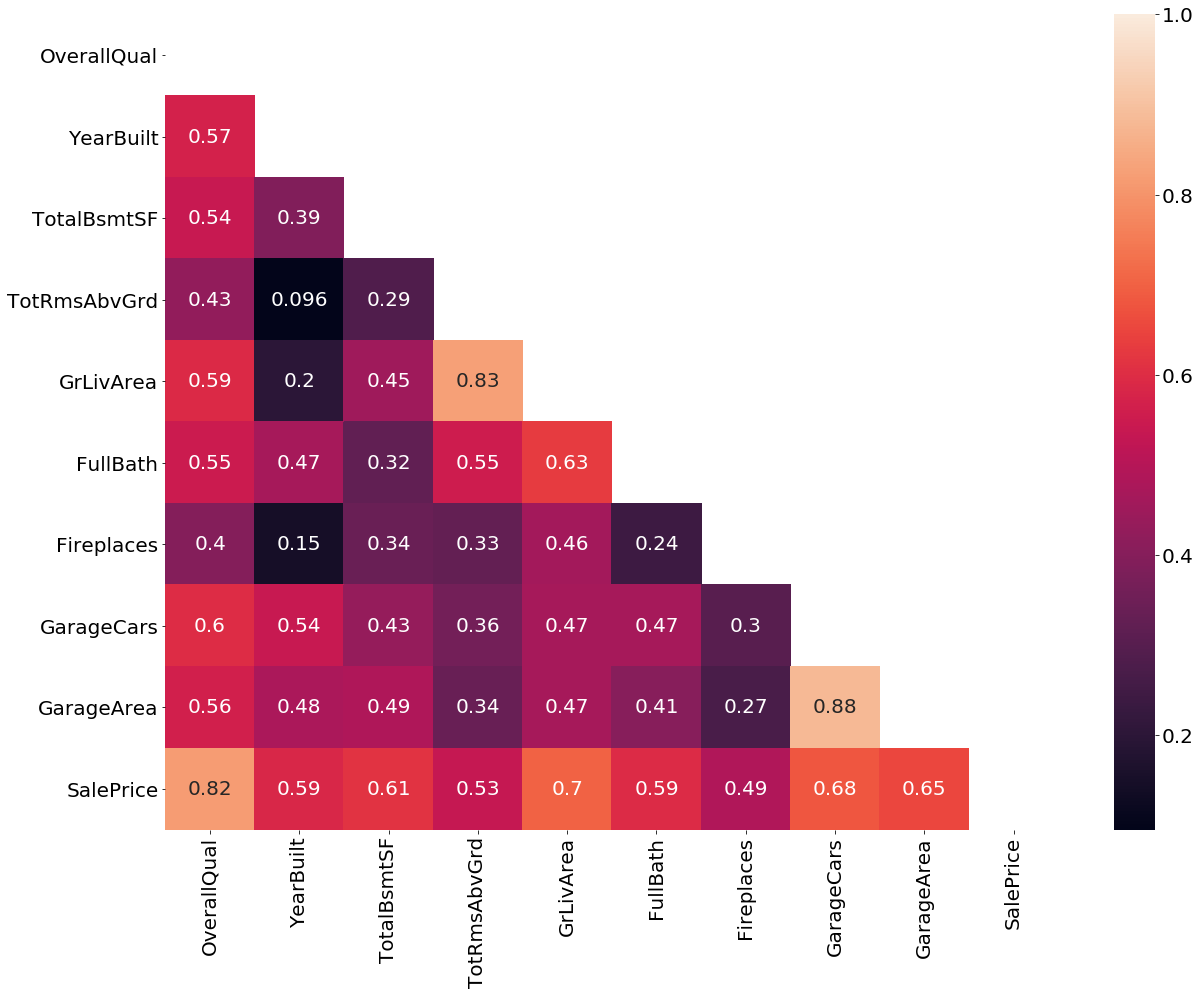

In [22]:
corr_test = train[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GrLivArea', 
                   'FullBath', 'Fireplaces', 'GarageCars', 'GarageArea', 'SalePrice']]

corr_zoom = corr_test.corr()
mask = np.zeros_like(corr_zoom)
mask[np.triu_indices_from(mask)] = True

_ = sns.heatmap(corr_zoom, mask = mask, annot=True)


The variables are potentially duplicated, for exmaple:

TotRmsAbvGrd - GrLivArea
GarageArea - GarageCars

Merging these variables will be rewarding, so our new list of important variables will be
'OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'Fireplaces', 'GarageCars'

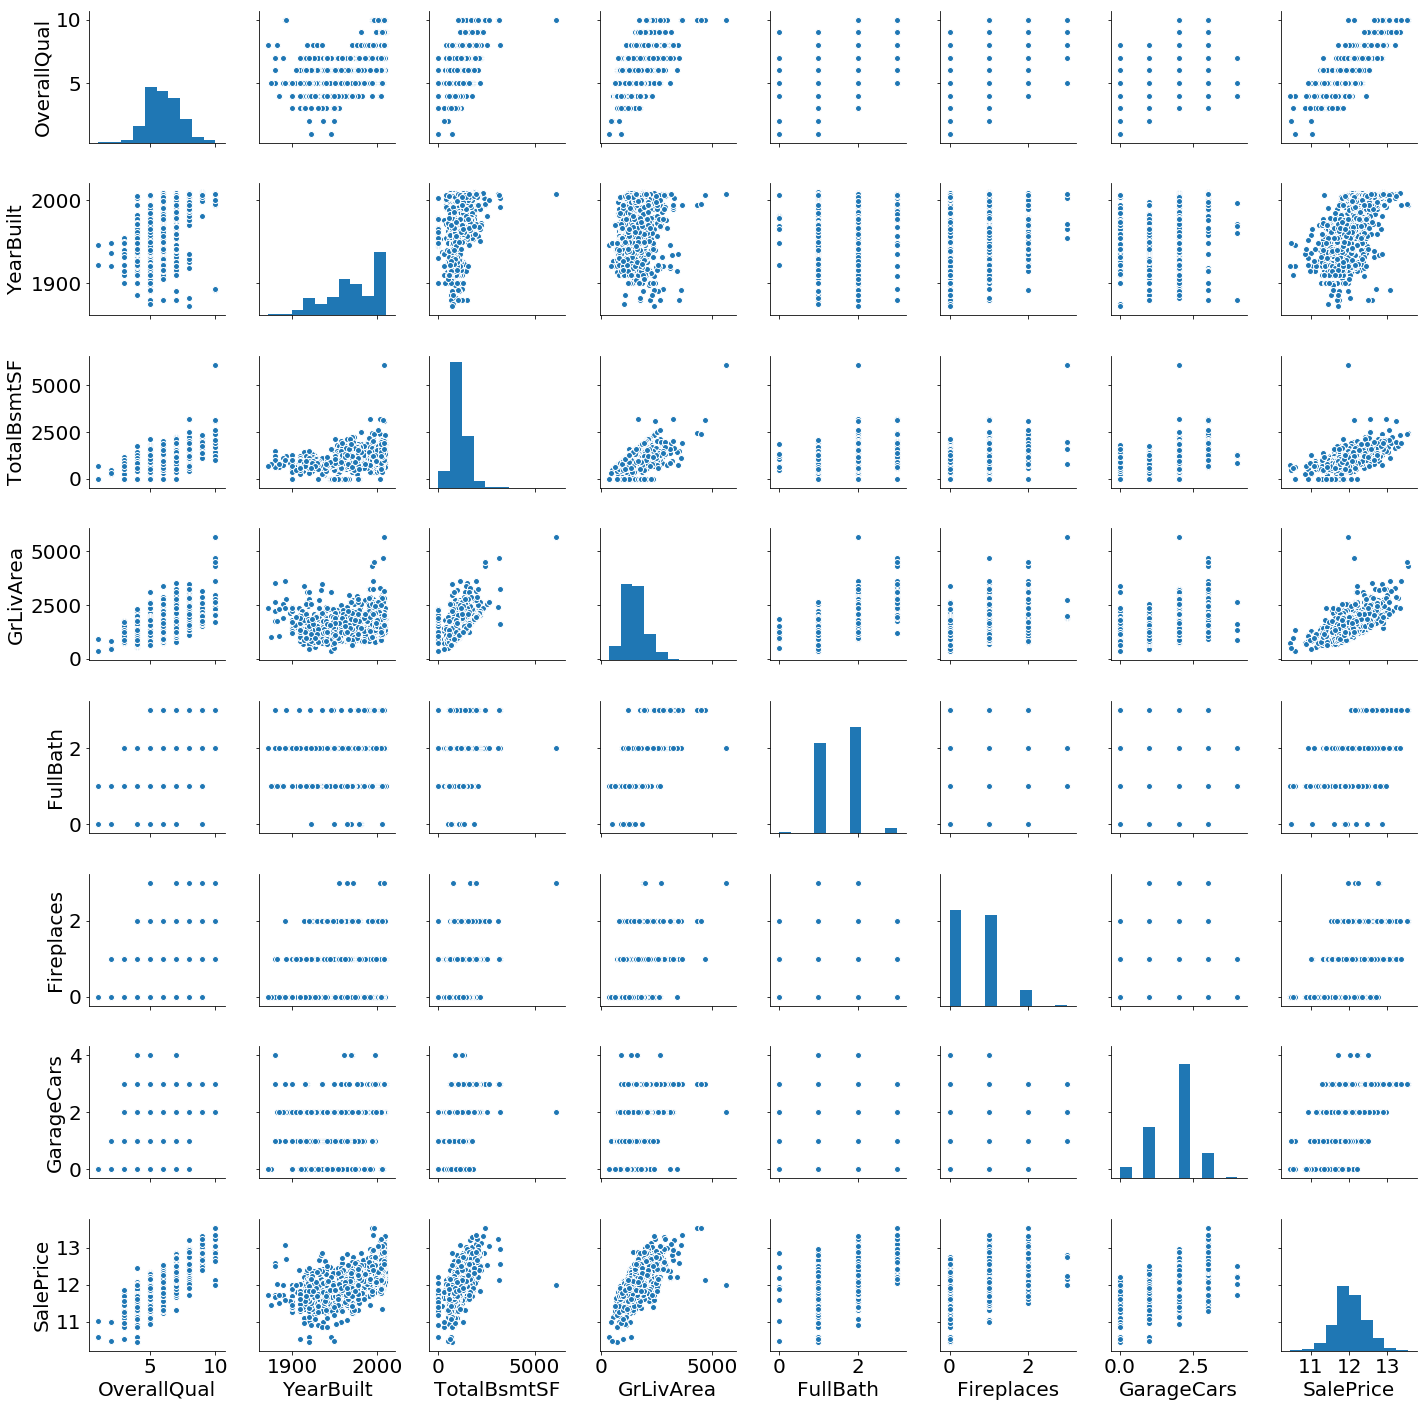

In [23]:
df_train = train[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'Fireplaces', 'GarageCars', 'SalePrice']]

sns.pairplot(df_train)

We can see there are outliers in both TotalBsmtSF and GrLivArea, which is not preferred in the regression we will perform later, henceforth we will remove those with total area >6000. 


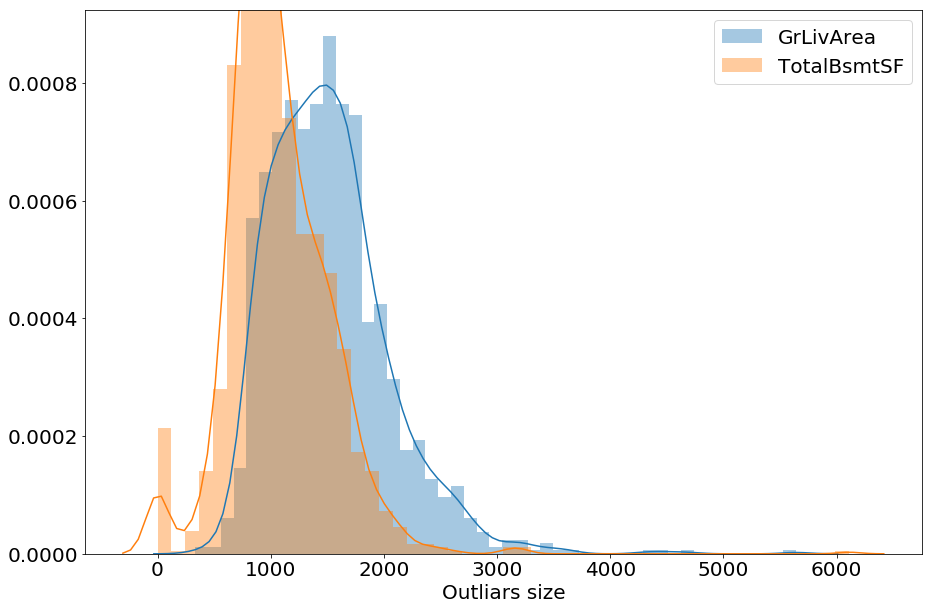

In [46]:
plt.figure(figsize=(15,10))
sns.distplot(train['GrLivArea'], label='GrLivArea')
sns.distplot(train['TotalBsmtSF'], label='TotalBsmtSF')
plt.legend()
plt.xlabel('Outliars size')

We see GrLivArea above 4000 don't appear very often, also around 3200 for TotalBsmtSF

In [75]:
mod_train = train[(train['GrLivArea']<4000) & (train['TotalBsmtSF']<3200)]
df_train = mod_train[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'Fireplaces', 'GarageCars', 'SalePrice']]

Location, location, location. For the purpose of illustration, I will exponentiate the SalePrice back up to see the true difference of each neighborhood in terms of the average sale price per house

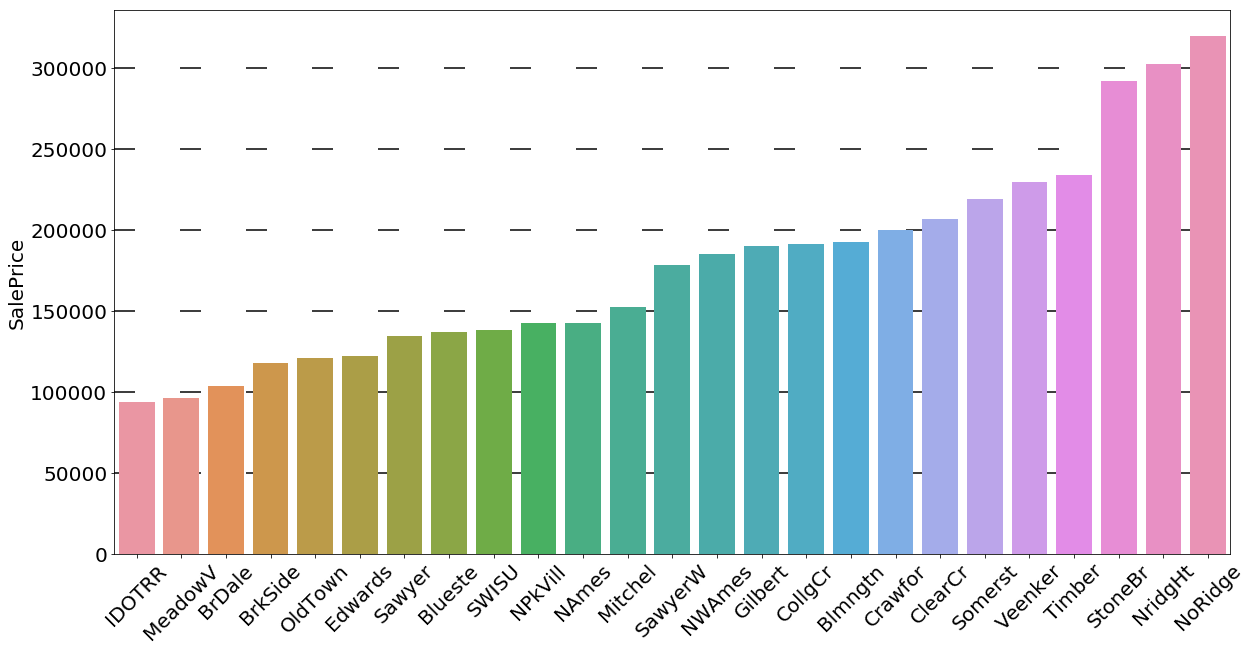

In [87]:
nbgh_group = train.groupby('Neighborhood')

nbgh_avg_price = nbgh_group['SalePrice'].mean().sort_values().apply(math.exp)
nbgh_names = nbgh_avg_price.index

plt.figure(figsize=(20,10))

sns.barplot(np.arange(nb_nbghs), nbgh_avg_price)

for i in range(50000, 350000, 50000):
    plt.axhline(y=i, dashes=[14,30], color='#000000', zorder=-1)

plt.xticks(np.arange(nb_nbghs), nbgh_names, rotation=45)
plt.show()

We should also consider the effects of sale conditions on the house price

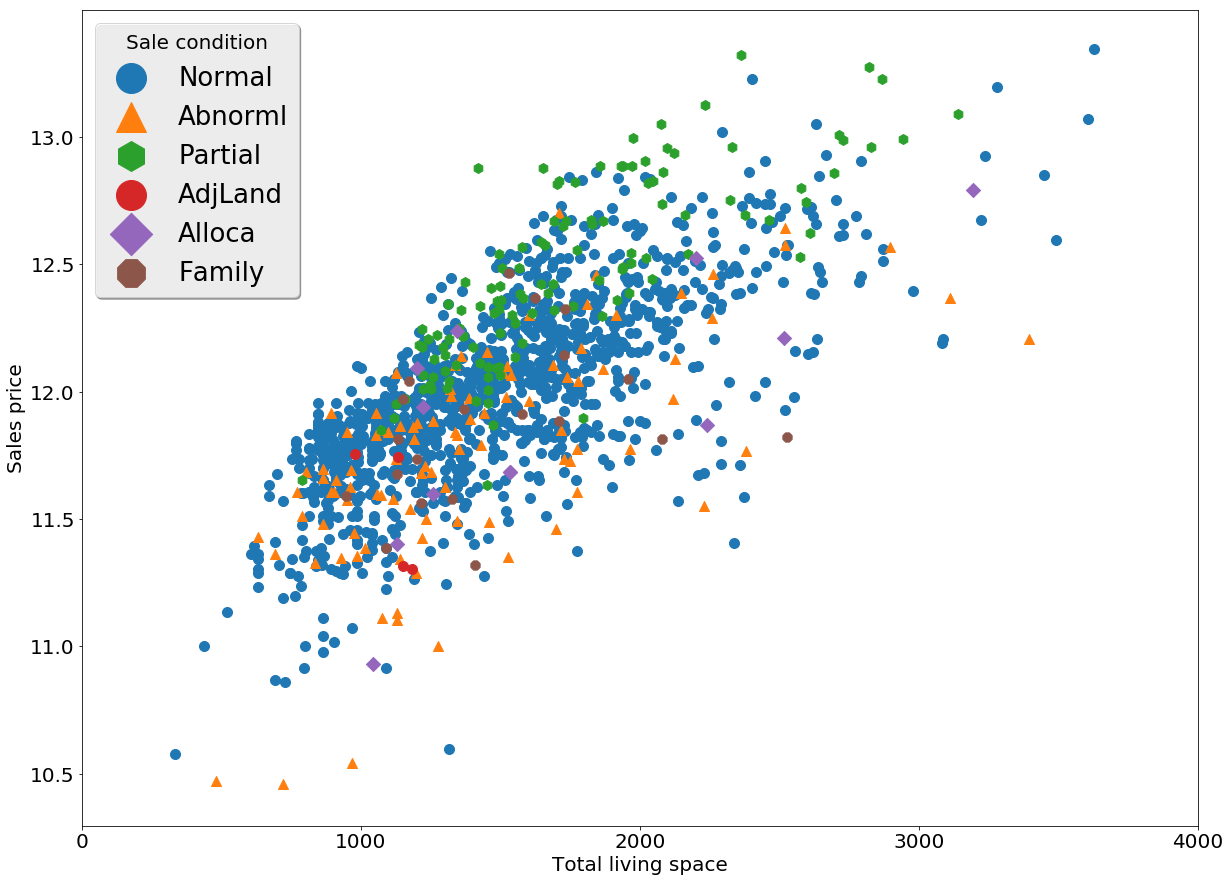

In [68]:
markers = ['o','^','h','o','D','8']
cat_performance={}

for i, cat in enumerate(train['SaleCondition'].unique()):
    cat_price = df_train[df_train['SaleCondition']==cat]['SalePrice']
    cat_size = df_train[df_train['SaleCondition']==cat]['GrLivArea']
    _ = plt.scatter(cat_size, cat_price, s=100, marker= markers[i],label=cat)

_ = plt.xticks(np.arange(1,13), np.arange(1,13))
_ = plt.legend(prop={'size':26}, shadow=True, title='Sale condition', handleheight=0.8, markerscale =3)
# _ = plt.xlim(0,5000)
# _ = plt.ylim(0,600000)
_ = plt.xticks(np.arange(0,5000,1000), np.arange(0,5000,1000))
_ = plt.xlabel('Total living space')
_ = plt.ylabel('Sales price')

Despite the correlation map suggestions, month in the year actually affects the average sale price too, this has to do with supply and demand which the correlation map didn't explicitly show

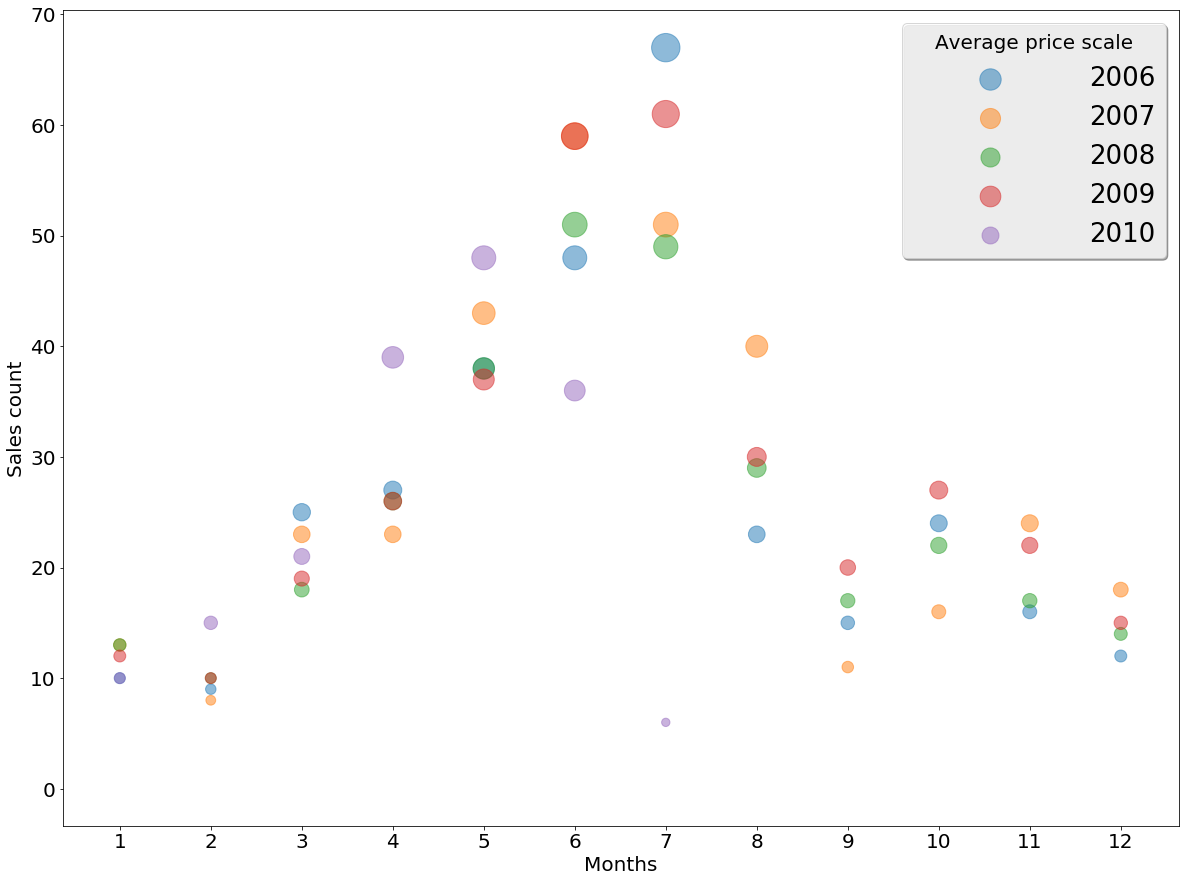

In [71]:

year_performance={}

for year in range(2006, 2011):
     
    month_performance=[]
    month_peravg = []
    that_year = train[train['YrSold']==year]
    
    for month in range(1,13):
  
        that_month = that_year[that_year['MoSold']==month]['SalePrice'].count()
        month_avg = that_year[that_year['MoSold']==month]['SalePrice'].sum()
        month_performance.append(that_month)
        month_peravg.append(month_avg)
    
    _ = plt.scatter(np.arange(1,13), month_performance, s=month_peravg, alpha=0.5, label=str(year))

_ = plt.xticks(np.arange(1,13), np.arange(1,13))
_ = plt.legend(prop={'size':26}, shadow=True, title='Average price scale', handlelength=6)
_ = plt.xlabel('Months')
_ = plt.ylabel('Sales count')


As we can see May to July are peak months in the real estate market and the sale prices generally increase accordingly, with that in mind we will also in clude that as a result. We can almost move on to the modeling part now, we just need to tokenize some of the verbal variables

0.0202299115472 0.0202403541625


c:\users\chester\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


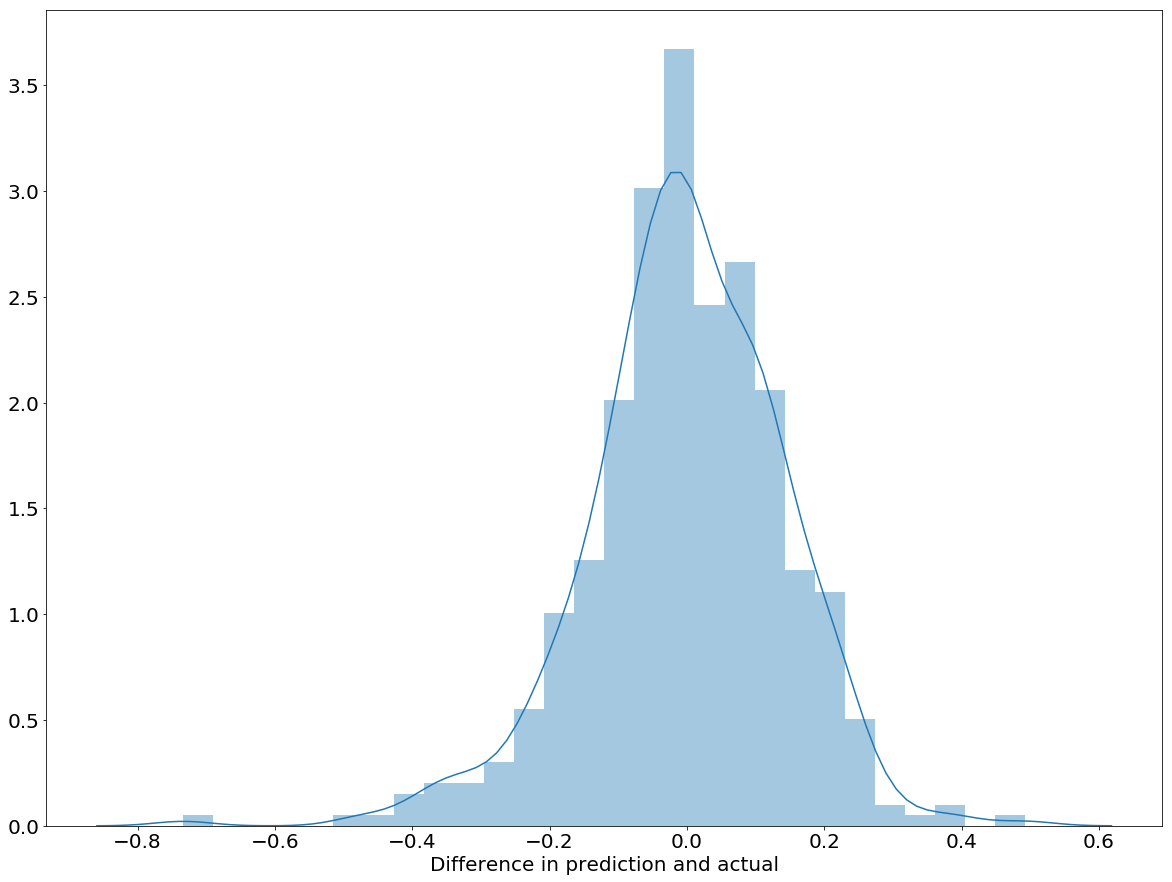

In [85]:
nbgh_onehot = pd.get_dummies(mod_train['Neighborhood'])
cond_onehot = pd.get_dummies(mod_train['SaleCondition'])
mon_onehot = pd.get_dummies(mod_train['MoSold'])

linreg_df = df_train.join([nbgh_onehot, cond_onehot, mon_onehot]).drop('SalePrice', axis=1)
target_var = df_train['SalePrice']

X_train = linreg_df.iloc[:1000]
y_train = target_var.iloc[:1000]

X_test = linreg_df.iloc[1000:]
y_test = target_var.iloc[1000:]

lin_reg = LinearRegression()
lin_ridge = Ridge(alpha=3)
lin_reg.fit(X_train, y_train)
lin_ridge.fit(X_train, y_train)

test_predict = lin_reg.predict(X_test)
test_predict2 = lin_ridge.predict(X_test)

print (mean_squared_error(test_predict, y_test), mean_squared_error(test_predict2, y_test))

diff = y_test - test_predict
_=sns.distplot(diff)
_=plt.xlabel('Difference in prediction and actual')
_=plt.legend()


In [84]:
test = pd.read_csv('test.csv')
df_test = test.fillna(0)

test_nbgh = pd.get_dummies(df_test['Neighborhood'])
test_cond = pd.get_dummies(df_test['SaleCondition'])
test_mon = pd.get_dummies(df_test['MoSold'])

reg_test = df_test[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 
                    'FullBath', 'Fireplaces', 'GarageCars']].join([test_nbgh, test_cond, test_mon])

submit = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.exp(lin_ridge.predict(reg_test))})
submit.to_csv('submit.csv', index=False)